<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-файлов" data-toc-modified-id="Загрузка-файлов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка файлов</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

<p><strong>Описание проекта</strong></p>
<ul>
<div class="paragraph">Сетевой супермаркет &laquo;Хлеб-Соль&raquo; внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:</div>
<ul>
<li>Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;</li>
<li>Контролировать добросовестность кассиров при продаже алкоголя.</li>
</ul>
<p>Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.</p>
</ul>
<p><strong>Задачи проекта</strong></p>
<ul>
<li>Провести исследовательский анализ набора фотографий;</li>
<li>Подготовить данные к обучению;</li>
<li>Обучить нейронную сеть и добиться метрики MAE меньше 8.</li>
</ul>

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Загрузка файлов

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [11]:
print(labels.info())
print('\n Количество дубликатов:', labels.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

 Количество дубликатов: 0


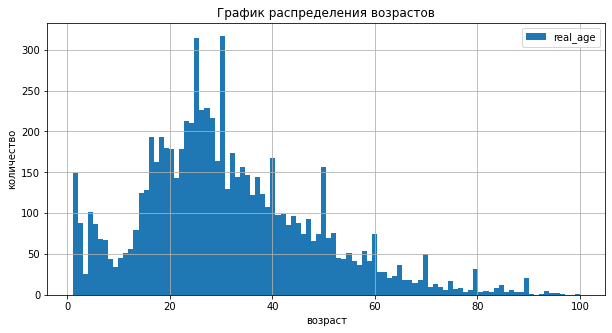

In [12]:
labels.plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
plt.xlabel('возраст')
plt.ylabel('количество')
plt.title('График распределения возрастов')
plt.show()

In [13]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


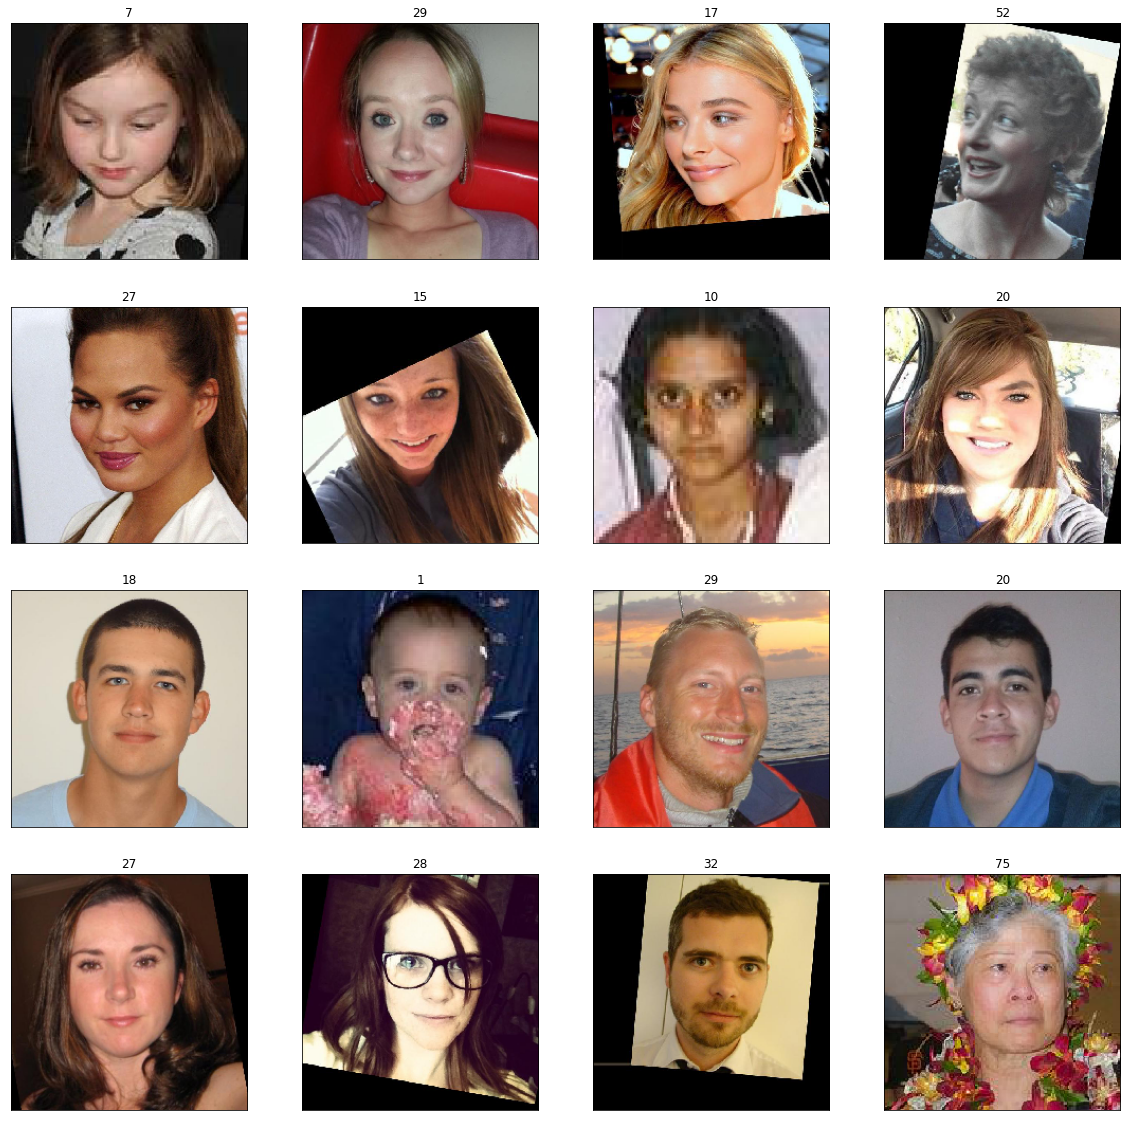

In [26]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])

<p><strong>Вывод</strong></p>
<ul>
<li>В датасете 7591 изображений, дубликатов нет;</li>
<li>Возраст на фотографиях от 1 до 100 лет, средний возраст 20-40 лет, имеются пики на "круглых" датах, после 60 лет виден спад количества фотографий, возможно на этих возрастах модель отработает хуже. Много фотографий детей до 10 лет - одна из целевых аудиторий прикассовой зоны.</li>
<li>Большинство фотографий выглядит хорошо, но есть фото с шумами, на некоторых лицо закрыто посторонними предметами.&nbsp;</li>
</ul>

## Обучение модели

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255,
                                       horizontal_flip=True)
                                       
                                       
    directory = path +'/final_files'
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255)
    directory = path +'/final_files'
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    optimizer = Nadam(lr=0.0001)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 101s - loss: 196.3568 - mae: 10.0964 - val_loss: 547.6001 - val_mae: 18.3618
Epoch 2/10
178/178 - 68s - loss: 65.0298 - mae: 6.1470 - val_loss: 548.7813 - val_mae: 18.2175
Epoch 3/10
178/178 - 67s - loss: 40.9004 - mae: 4.8740 - val_loss: 281.0348 - val_mae: 12.1560
Epoch 4/10
178/178 - 67s - loss: 29.1214 - mae: 4.0998 - val_loss: 122.3333 - val_mae: 8.2174
Epoch 5/10
178/178 - 67s - loss: 22.0404 - mae: 3.5495 - val_loss: 77.8151 - val_mae: 6.6185
Epoch 6/10
178/178 - 67s - loss: 16.6632 - mae: 3.0569 - val_loss: 69.9068 - val_mae: 6.1594
Epoch 7/10
178/178 - 67s - loss: 13.3935 - mae: 2.7317 - val_loss: 64.8237 - val_mae: 6.0339
Epoch 8/10
178/178 - 66s - loss: 11.4846 - mae: 2.5284 - val_loss: 66.9794 - val_mae: 6.3095
Epoch 9/10
178/178 - 57s - loss: 9.4058 - mae: 2.2861 - val_loss: 63.1486 - val_mae: 5.8869
Epoch 10/10
178/178 - 42s - loss: 7.8468 - mae: 2.1168 - val_loss: 61.1916 - val_mae: 5.8260

60/60 - 10s - loss: 61.1916 - mae: 5.8260
Test MAE: 5.8260

```

## Анализ обученной модели

Обучив и проверив модель на 10 эпохах, получили метрику MAE: 5.8260, что можно считать прекрасным результатом.

Возможно, применив 50 эпох ошибка стала бы меньше, но по ТЗ МАЕ должна быть меньше 8, соответственно задание выполнено.

Заменив оптимизатор ADAM на NADAM увеличили метрику на несколько пунктов.

Средняя ошибка составила 6 лет, что для взрослого населения не является значимой погрешностью, исключение составляют дети, а также ошибка является довольно большой для определения возраста продажи алкоголя и табачной продукции.